### Check if configuration has been run already and change directory to repository root:

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datajoint as dj
import pandas as pd
import u19_pipeline.automatic_job.recording_handler as rec_handler
import u19_pipeline.automatic_job.recording_process_handler as rec_process_handler

from u19_pipeline import recording, lab

#import utility.dj_shortcuts as dj_short
#import utility.acquisition_pipeline_handler as aph
dj.__version__

Connecting alvaros@datajoint00.pni.princeton.edu:3306


'0.13.2'

In [3]:
from u19_pipeline.ephys_pipeline import ephys_element

In [4]:
cat_gt_params =  {
      "apfilter": ["biquad",2,300,0],
      "gfix": [0.40,0.10,0.02],
      "extras": ["prb_fld", "t_miss_ok", "ap", "gblcar", "out_prb_fld"]
   }
 
ephys_element.PreClusterParamSet.insert_new_params(
    precluster_method='catgt',
    paramset_idx=0,
    params=cat_gt_params,
    paramset_desc='Spike sorting using Kilosort2')
 


paramset_idx,precluster_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,catgt,Spike sorting using Kilosort2,4271fe75-1732-5821-0070-45b4c286e867,=BLOB=


In [5]:
ephys_element.PreClusterParamSet()

paramset_idx,precluster_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,catgt,Spike sorting using Kilosort2,4271fe75-1732-5821-0070-45b4c286e867,=BLOB=
1,catgt,Spike sorting using Kilosort2,3d1047b9-deec-bc7f-d5a5-4e30c1665f07,=BLOB=


In [5]:
cat_gt_params =  {
      "apfilter": ["biquad",2,301,0],
      "gfix": [0.40,0.10,0.02],
      "extras": ["prb_fld", "t_miss_ok", "ap", "gblcar", "out_prb_fld"]
   }
 
ephys_element.PreClusterParamSet.insert_new_params(
    precluster_method='catgt',
    paramset_idx=1,
    params=cat_gt_params,
    paramset_desc='Spike sorting using Kilosort2')
 

In [5]:
paramlist = {'precluster_param_list_id':0}
ephys_element.PreClusterParamList.insert1(paramlist)

paramorder = {
'precluster_param_list_id': 0,
'order_id': 1,
'paramset_idx': 0
}
ephys_element.PreClusterParamList.ParamOrder.insert1(paramorder)




precluster_param_list_id,order_id Order of operations,paramset_idx
0,1,0


In [6]:
paramlist = {'precluster_param_list_id':1}
ephys_element.PreClusterParamList.insert1(paramlist)

paramorder = {
'precluster_param_list_id': 1,
'order_id': 1,
'paramset_idx': 1
}
ephys_element.PreClusterParamList.ParamOrder.insert1(paramorder)

In [14]:
paramlist = {'precluster_param_list_id':2}
ephys_element.PreClusterParamList.insert1(paramlist)

paramorder = {
'precluster_param_list_id': 2,
'order_id': 1,
'paramset_idx': 0
}
ephys_element.PreClusterParamList.ParamOrder.insert1(paramorder)
paramorder = {
'precluster_param_list_id': 2,
'order_id': 2,
'paramset_idx': 1
}
ephys_element.PreClusterParamList.ParamOrder.insert1(paramorder)

In [15]:
ephys_element.PreClusterParamList.ParamOrder()

precluster_param_list_id,order_id Order of operations,paramset_idx
0,1,0
2,1,0
1,1,1
2,2,1


In [15]:
params = {
 "fs": 30000,
 "fshigh": 150,
 "minfr_goodchannels": 0.1,
 "Th": [10, 4],
 "lam": 10,
 "AUCsplit": 0.9,
 "minFR": 0.02,
 "momentum": [20, 400],
 "sigmaMask": 30,
 "ThPre": 8,
 "CAR": 1, 
 "spkTh": -6,
 "reorder": 1,
 "nskip": 25,
 "GPU": 2,
 "Nfilt": 1024,
 "nfilt_factor": 4,
 "ntbuff": 64,
 "NT": 32832,
 "whiteningRange": 32,
 "nSkipCov": 25,
 "scaleproc": 200,
 "nPCs": 3,
 "useRAM": 0,
 "trange": [0, 1000000000],
"NchanTOT": 384
}

ephys_element.ClusteringParamSet.insert_new_params(
    processing_method='kilosort2',
    paramset_idx=1,
    params=params,
    paramset_desc='Spike sorting using Kilosort2')




In [8]:
ephys_element.ClusteringParamSet()

paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,b9e07e55-95ea-3463-a740-90291de41da6,=BLOB=
1,kilosort2,Spike sorting using Kilosort2,697d24ac-2d46-a6e8-6f6b-2d1afaea000d,=BLOB=


In [7]:
default_params_key = dict()
default_params_key['recording_id'] = 39
default_params_key['fragment_number'] = 0
default_params_key['pre_param_list_id'] = 0
default_params_key['paramset_idx'] = 0


recording.DefaultParams.insert1(default_params_key)

In [16]:
default_params_key = dict()
default_params_key['recording_id'] = 41
default_params_key['fragment_number'] = 0
default_params_key['pre_param_list_id'] = 2
default_params_key['paramset_idx'] = 0


recording.DefaultParams.insert1(default_params_key)

In [8]:
default_params_key = dict()
default_params_key['recording_id'] = 40
default_params_key['fragment_number'] = 0
default_params_key['pre_param_list_id'] = 0
default_params_key['paramset_idx'] = 0
default_params_key['default_same_preparams_all'] = 0
default_params_key['default_same_params_all'] = 0

recording.DefaultParams.insert1(default_params_key)

default_params_key = dict()
default_params_key['recording_id'] = 40
default_params_key['fragment_number'] = 1
default_params_key['pre_param_list_id'] = 0
default_params_key['paramset_idx'] = 1
default_params_key['default_same_preparams_all'] = 0
default_params_key['default_same_params_all'] = 0

recording.DefaultParams.insert1(default_params_key)

default_params_key = dict()
default_params_key['recording_id'] = 40
default_params_key['fragment_number'] = 2
default_params_key['pre_param_list_id'] = 1
default_params_key['paramset_idx'] = 0
default_params_key['default_same_preparams_all'] = 0
default_params_key['default_same_params_all'] = 0

recording.DefaultParams.insert1(default_params_key)

default_params_key = dict()
default_params_key['recording_id'] = 40
default_params_key['fragment_number'] = 3
default_params_key['pre_param_list_id'] = 1
default_params_key['paramset_idx'] = 1
default_params_key['default_same_preparams_all'] = 0
default_params_key['default_same_params_all'] = 0


recording.DefaultParams.insert1(default_params_key)


In [9]:
recording.DefaultParams()

recording_id Unique number assigned to recording,fragment_number probe/field_of_view # if not always the same,default_same_preparams_all by default all probes/fields of view have same preparameters,pre_param_list_id preparams index for recording (could be imaging/ephys),default_same_params_all by default all probes/fields of view have same parameters,paramset_idx params index for recording (could be imaging/ephys)
39,0,1,0,1,0
40,0,0,0,0,0
40,1,0,0,0,1
40,2,0,1,0,0
40,3,0,1,0,1


In [10]:
ephys_pipeline_db = dj.create_virtual_module('ephys_pipeline', 'u19_ephys_pipeline')



In [11]:
ephys_pipeline_db.EphysPipelineSession.delete()

Deleting 3 rows from `u19_pipeline_ephys_element`.`_ephys_recording__ephys_file`
Deleting 3 rows from `u19_pipeline_ephys_element`.`_ephys_recording`
Deleting 3 rows from `u19_pipeline_ephys_element`.`probe_insertion`
Deleting 2 rows from `u19_ephys_pipeline`.`__ephys_pipeline_session`
Deletes committed.


2

In [12]:
rec_series = dict()
rec_series['query_key'] = {'recording_id': 39}

import u19_pipeline.ephys_pipeline as ephys_pipeline
import u19_pipeline.recording_process as recording_process

probe_files = (ephys_pipeline.ephys_element.EphysRecording.EphysFile & rec_series['query_key']).fetch("KEY")
probe_files

#recording_process.Processing().insert_recording_process(probe_files, 'insertion_number')

[]

In [8]:
import u19_pipeline.ephys_pipeline as ephys_pipeline
import u19_pipeline.recording_process as recording_process

rec_series = dict()
rec_series['query_key'] = {'recording_id': 40}

probe_files = (ephys_pipeline.ephys_element.EphysRecording.EphysFile & rec_series['query_key']).fetch("KEY")
recording_process.Processing().insert_recording_process(probe_files, 'insertion_number')

recording_processes = (recording_process.Processing() & rec_series['query_key']).fetch('job_id', 'recording_id', 'fragment_number', as_dict=True)
default_params_record_df = pd.DataFrame((recording.DefaultParams & rec_series['query_key']).fetch(as_dict=True))

params_rec_process = recording.DefaultParams.get_default_params_rec_process(recording_processes, default_params_record_df)

params_rec_process

recording_processes...... [{'job_id': 42, 'recording_id': 40, 'fragment_number': 0}, {'job_id': 43, 'recording_id': 40, 'fragment_number': 1}, {'job_id': 44, 'recording_id': 40, 'fragment_number': 2}, {'job_id': 45, 'recording_id': 40, 'fragment_number': 3}]
this_params_rec_process {'job_id': 42}
this_params_rec_process {'job_id': 42, 'precluster_param_list_id': 0, 'paramset_idx': 0}
this_params_rec_process {'job_id': 43}
this_params_rec_process {'job_id': 43, 'precluster_param_list_id': 0, 'paramset_idx': 1}
this_params_rec_process {'job_id': 44}
this_params_rec_process {'job_id': 44, 'precluster_param_list_id': 1, 'paramset_idx': 0}
this_params_rec_process {'job_id': 45}
this_params_rec_process {'job_id': 45, 'precluster_param_list_id': 1, 'paramset_idx': 1}


[{'job_id': 42, 'precluster_param_list_id': 0, 'paramset_idx': 0},
 {'job_id': 43, 'precluster_param_list_id': 0, 'paramset_idx': 1},
 {'job_id': 44, 'precluster_param_list_id': 1, 'paramset_idx': 0},
 {'job_id': 45, 'precluster_param_list_id': 1, 'paramset_idx': 1}]

In [4]:
l = rec_handler.RecordingHandler.pipeline_handler_main()

In [4]:
l = rec_process_handler.RecProcessHandler.pipeline_handler_main()

directory_path recording_process_pre_path
process_cluter: tiger
si fue tiger
['globus-timer', 'job', 'transfer', '--name', 'job_id_57_raw_transfer', '--label', 'job_id_57_raw_transfer', '--interval', '72h', '--stop-after-date', '2022-05-11T23:59:59', '--source-endpoint', '6ce834d6-ff8a-11e6-bad1-22000b9a448b', '--dest-endpoint', 'a9df83d2-42f0-11e6-80cf-22000b1701d1', '--item', '/mnt/cup/braininit/Data/Raw/electrophysiology/ms81/ms81_M011/20211116/TowersTask_g0/TowersTask_g0_imec1', '/tiger/scratch/gpfs/BRAINCOGS/Data/Raw/electrophysiology/ms81/ms81_M011/20211116/TowersTask_g0/TowersTask_g0_imec1', 'true', '--verbose']
p.stdout b'{\n  "name": "job_id_57_raw_transfer",\n  "start": "2022-05-11T05:11:54+00:00",\n  "stop_after": {\n    "date": "2022-05-12T04:59:59",\n    "n_runs": null\n  },\n  "interval": 259200.0,\n  "callback_url": "https://actions.automate.globus.org/transfer/transfer/run",\n  "callback_body": {\n    "body": {\n      "source_endpoint_id": "6ce834d6-ff8a-11e6-bad1-22000

In [59]:
import u19_pipeline.utils.dj_shortcuts as dj_short
from u19_pipeline import ephys_pipeline, imaging_pipeline
import u19_pipeline.recording_process as recording_process
from u19_pipeline import utility

status_query = 'status_processing_id > ' + str(-1)
status_query += ' and status_processing_id < ' + str(10)


jobs_active = (recording.Recording.proj('recording_modality') * \
    recording_process.Processing & status_query)
df_process_jobs = pd.DataFrame(jobs_active.fetch(as_dict=True))

if df_process_jobs.shape[0] > 0:
    key_list = dj_short.get_primary_key_fields(recording_process.Processing)
    df_process_jobs['query_key'] = df_process_jobs.loc[:, key_list].to_dict(orient='records')

all_modalities = df_process_jobs['recording_modality'].unique()
for this_modality in all_modalities:

    this_mod_df = df_process_jobs.loc[df_process_jobs['recording_modality'] == this_modality,:]
    these_process_keys = this_mod_df['query_key'].to_list()

    if this_modality == 'electrophysiology':

        params_df = pd.DataFrame((ephys_pipeline.ephys_element.ClusteringParamSet.proj('params') * \
        recording_process.Processing.EphysParams.proj('paramset_idx') \
        & these_process_keys).fetch(as_dict=True))
        params_df = params_df.drop('paramset_idx', axis=1)

        preparams_df = pd.DataFrame((ephys_pipeline.ephys_element.PreClusterParamList * \
        utility.smart_dj_join(ephys_pipeline.ephys_element.PreClusterParamList.ParamOrder, ephys_pipeline.ephys_element.PreClusterParamSet.proj('precluster_method', 'params')) *
        recording_process.Processing.EphysParams.proj('precluster_param_list_id') \
        & these_process_keys).fetch(as_dict=True))
        
        preparams_df['preparams'] = preparams_df.apply(lambda x : {x['precluster_method']: x['params']}, axis=1)
        preparams_df = preparams_df.sort_values(by=['job_id', 'order_id'])
        preparams_df = preparams_df[['job_id', 'preparams']].groupby("job_id").agg(lambda x: list(x))
        preparams_df = preparams_df.reset_index()

        params_df = params_df.merge(preparams_df)
        df_process_jobs = df_process_jobs.merge(params_df, how='left')


df_process_jobs


,recording_id,job_id,recording_modality,status_processing_id,fragment_number,recording_process_pre_path,recording_process_post_path,task_copy_id_pre,task_copy_id_post,slurm_id,query_key,params,preparams
0,39,46,electrophysiology,0,0,None,None,None,None,None,{'job_id': 46},"{'fs': 30000, 'fshigh': 150, 'minfr_goodchanne...","[{'catgt': {'apfilter': ['biquad', 2, 300, 0],..."
1,39,47,electrophysiology,0,1,None,None,None,None,None,{'job_id': 47},"{'fs': 30000, 'fshigh': 150, 'minfr_goodchanne...","[{'catgt': {'apfilter': ['biquad', 2, 300, 0],..."
2,39,48,electrophysiology,0,2,None,None,None,None,None,{'job_id': 48},"{'fs': 30000, 'fshigh': 150, 'minfr_goodchanne...","[{'catgt': {'apfilter': ['biquad', 2, 300, 0],..."
3,40,49,electrophysiology,0,0,None,None,None,None,None,{'job_id': 49},"{'fs': 30000, 'fshigh': 150, 'minfr_goodchanne...","[{'catgt': {'apfilter': ['biquad', 2, 300, 0],..."
4,40,50,electrophysiology,0,1,None,None,None,None,None,{'job_id': 50},"{'fs': 30000, 'fshigh': 150, 'minfr_goodchanne...","[{'catgt': {'apfilter': ['biquad', 2, 300, 0],..."
5,40,51,electrophysiology,0,2,None,None,None,None,None,{'job_id': 51},"{'fs': 30000, 'fshigh': 150, 'minfr_goodchanne...","[{'catgt2': {'apfilter': ['biquad', 2, 301, 0]..."
6,40,52,electrophysiology,0,3,None,None,None,None,None,{'job_id': 52},"{'fs': 30000, 'fshigh': 150, 'minfr_goodchanne...","[{'catgt2': {'apfilter': ['biquad', 2, 301, 0]..."
7,41,53,electrophysiology,0,0,None,None,None,None,None,{'job_id': 53},"{'fs': 30000, 'fshigh': 150, 'minfr_goodchanne...","[{'catgt': {'apfilter': ['biquad', 2, 300, 0],..."
8,41,54,electrophysiology,0,1,None,None,None,None,None,{'job_id': 54},"{'fs': 30000, 'fshigh': 150, 'minfr_goodchanne...","[{'catgt': {'apfilter': ['biquad', 2, 300, 0],..."
9,41,55,electrophysiology,0,2,None,None,None,None,None,{'job_id': 55},"{'fs': 30000, 'fshigh': 150, 'minfr_goodchanne...","[{'catgt': {'apfilter': ['biquad', 2, 300, 0],..."


In [21]:
rec_series = dict()
rec_series['query_key'] = {'recording_id': 45}

old_recording_process = (recording_process.Processing() & rec_series['query_key']).fetch("KEY", as_dict=True)

len(old_recording_process)

0

In [6]:
import u19_pipeline.recording_process as recording_process
import u19_pipeline.ephys_pipeline as ephys_pipeline

#recording_process.Processing.delete()
ephys_pipeline.EphysPipelineSession.delete()

Deleting 10 rows from `u19_pipeline_ephys_element`.`_ephys_recording__ephys_file`
Deleting 10 rows from `u19_pipeline_ephys_element`.`_ephys_recording`
Deleting 10 rows from `u19_pipeline_ephys_element`.`probe_insertion`
Deleting 3 rows from `u19_ephys_pipeline`.`__ephys_pipeline_session`
Deletes committed.


3

In [6]:
dj.ERD(recording) -1 + dj.ERD(recording_process) + dj.ERD(ephys_pipeline) + 1


NameError: name 'recording_process' is not defined

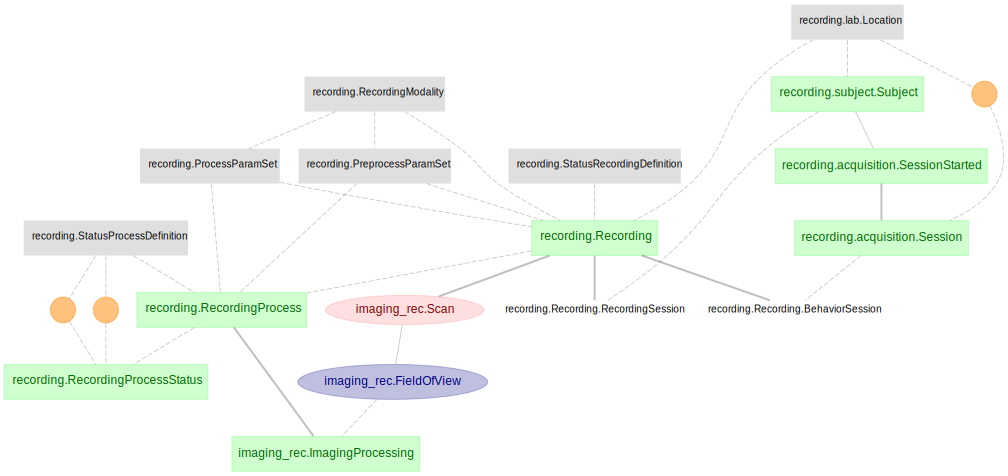

In [13]:
dj.ERD(recording) -1 + dj.ERD(imaging_rec.Scan) + dj.ERD(imaging_rec.ImagingProcessing) 


In [7]:
s = b'Name:            job_id_56_raw_transfer\nJob ID:          191f4b51-ddb8-41e3-b14c-728e3ec05403\nStatus:          new\nStart:           2022-05-11T04:18:17+00:00\nInterval:        3 days, 0:00:00\nNext Run At:     2022-05-11T04:18:17+00:00\nLast Run Result: NOT RUN\n'

s

b'Name:            job_id_56_raw_transfer\nJob ID:          191f4b51-ddb8-41e3-b14c-728e3ec05403\nStatus:          new\nStart:           2022-05-11T04:18:17+00:00\nInterval:        3 days, 0:00:00\nNext Run At:     2022-05-11T04:18:17+00:00\nLast Run Result: NOT RUN\n'

In [22]:
u = s.decode('UTF-8')
n = u.split(sep='\n')

n2 = [x.split(sep=':', maxsplit=1) for x in n]

flat_list = [item for l in n2 for item in l]
flat_list2 = [x.strip() for x in flat_list]

#n2 = [x[:-1] for x in n if ]

d1 = dict(zip(flat_list2[::2], flat_list2[1::2]))
#d1

d1

{'Name': 'job_id_56_raw_transfer',
 'Job ID': '191f4b51-ddb8-41e3-b14c-728e3ec05403',
 'Status': 'new',
 'Start': '2022-05-11T04:18:17+00:00',
 'Interval': '3 days, 0:00:00',
 'Next Run At': '2022-05-11T04:18:17+00:00',
 'Last Run Result': 'NOT RUN'}

In [16]:
n[0][:-1]

'Name:            job_id_56_raw_transfe'

In [ ]:
globus-timer job transfer \
    --name job_id_56_raw_transfer \
    --label "job_id_56_raw_transfer" \
    --interval '72h' \
    --stop-after-date '2022-05-10T23:59:59' \
    --source-endpoint 6ce834d6-ff8a-11e6-bad1-22000b9a448b \
    --dest-endpoint a9df83d2-42f0-11e6-80cf-22000b1701d1 \
    --item '/mnt/cup/braininit/Data/Raw/electrophysiology/ms81/ms81_M011/20211116/TowersTask_g0/TowersTask_g0_imec0' '/tiger/scratch/gpfs/BRAINCOGS/Data/Raw/electrophysiology/ms81/ms81_M011/20211116/TowersTask_g0/TowersTask_g0_imec0' true

In [6]:
import u19_pipeline.recording_process as recording_process


s = pd.DataFrame(recording_process.Processing.fetch(as_dict=True))

s

,job_id,recording_id,status_processing_id,fragment_number,recording_process_pre_path,recording_process_post_path,task_copy_id_pre,task_copy_id_post,slurm_id
0,56,39,-1,0,ms81/ms81_M011/20211116/TowersTask_g0/TowersTa...,None,b5073818-daad-4a46-af50-6ec1519de31f,None,None
1,57,39,-1,1,ms81/ms81_M011/20211116/TowersTask_g0/TowersTa...,None,None,None,None
2,58,39,-1,2,ms81/ms81_M011/20211116/TowersTask_g0/TowersTa...,None,None,None,None
3,59,40,-1,0,ms81/ms81_M011/20211120/TowersTask_g0/TowersTa...,None,None,None,None
4,60,40,-1,1,ms81/ms81_M011/20211120/TowersTask_g0/TowersTa...,None,None,None,None
5,61,40,-1,2,ms81/ms81_M011/20211120/TowersTask_g0/TowersTa...,None,None,None,None
6,62,40,-1,3,ms81/ms81_M011/20211120/TowersTask_g0/TowersTa...,None,None,None,None
7,63,41,-1,0,ms81/ms81_M012/20211210/2021-12-10_g0/2021-12-...,None,None,None,None
8,64,41,-1,1,ms81/ms81_M012/20211210/2021-12-10_g0/2021-12-...,None,None,None,None
9,65,41,-1,2,ms81/ms81_M012/20211210/2021-12-10_g0/2021-12-...,None,None,None,None
